# Экзогенные переменные

## Импорт модулей

In [31]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,5)

## Данные

In [32]:
gas = pd.read_csv('data/gas.csv', index_col='Date', parse_dates=True)

In [33]:
gas.index.freq = 'D'

In [34]:
gas["const"] = 1

In [35]:
gas.head()

,Consumption,Mean temperature,const
Date,,,
2016-01-01,233.59,5.86,1
2016-01-02,250.99,6.87,1
2016-01-03,242.07,7.13,1
2016-01-04,286.05,7.28,1
2016-01-05,284.71,8.22,1


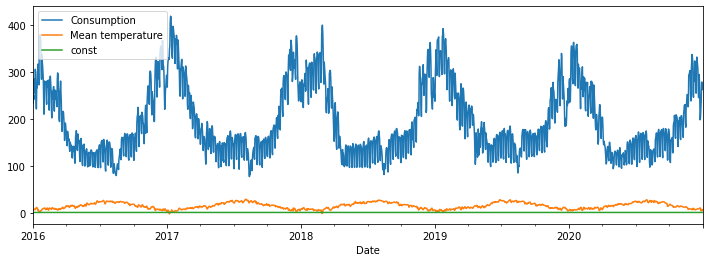

In [36]:
gas.plot(figsize=(12,4))
plt.show()

## Модель

In [37]:
prMean = gas[["Mean temperature", "const"]].groupby([gas.index.month, gas.index.day]).mean()
prMin = gas[["Mean temperature", "const"]].groupby([gas.index.month, gas.index.day]).min()
prMax = gas[["Mean temperature", "const"]].groupby([gas.index.month, gas.index.day]).max()

In [38]:
prMean.drop((2,29), axis=0, inplace=True)
prMin.drop((2,29), axis=0, inplace=True)
prMax.drop((2,29), axis=0, inplace=True)

In [39]:
model = SARIMAX(gas["Consumption"],
                exog=gas[["Mean temperature", "const"]],
                order=(3, 1, 1),
                seasonal_order=(2, 1, 1, 7)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.97868D+00    |proj g|=  5.45670D-02


 This problem is unconstrained.



At iterate    5    f=  3.94861D+00    |proj g|=  1.19669D-01

At iterate   10    f=  3.89290D+00    |proj g|=  2.41684D-02

At iterate   15    f=  3.89217D+00    |proj g|=  8.72421D-03

At iterate   20    f=  3.89029D+00    |proj g|=  2.42978D-03

At iterate   25    f=  3.88981D+00    |proj g|=  5.21762D-03

At iterate   30    f=  3.88875D+00    |proj g|=  1.57102D-03

At iterate   35    f=  3.88874D+00    |proj g|=  3.29319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     39     43      1     0     0   2.016D-05   3.889D+00
  F =   3.8887385240062415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [40]:
model.params

Mean temperature     -2.617975
const                -0.000002
ar.L1                -0.724299
ar.L2                -0.108482
ar.L3                -0.126113
ma.L1                 0.825636
ar.S.L7               0.176223
ar.S.L14              0.057214
ma.S.L7              -0.998700
sigma2              141.955285
dtype: float64

## Прогнозные коридоры

In [41]:
start = gas.index[-1] + pd.DateOffset(days=1)
end = start + pd.DateOffset(days=364)
start, end

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-12-31 00:00:00'))

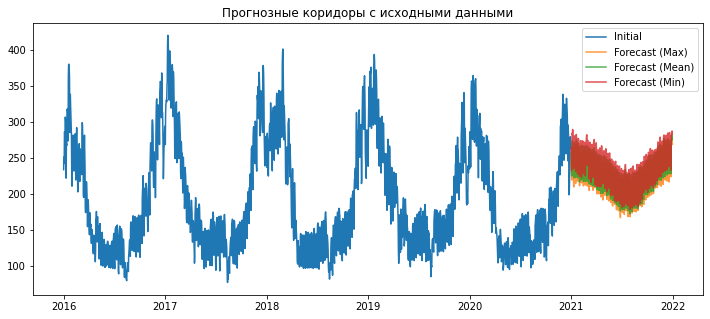

In [42]:
plt.plot(gas["Consumption"])
# model.forecast(365, exog=pr).plot()
plt.plot(model.predict(start=start, end=end, exog=prMax), alpha=0.8)
plt.plot(model.predict(start=start, end=end, exog=prMean), alpha=0.8)
plt.plot(model.predict(start=start, end=end, exog=prMin), alpha=0.8)
plt.legend(["Initial", "Forecast (Max)", "Forecast (Mean)", "Forecast (Min)"])
plt.title("Прогнозные коридоры с исходными данными")
plt.show()

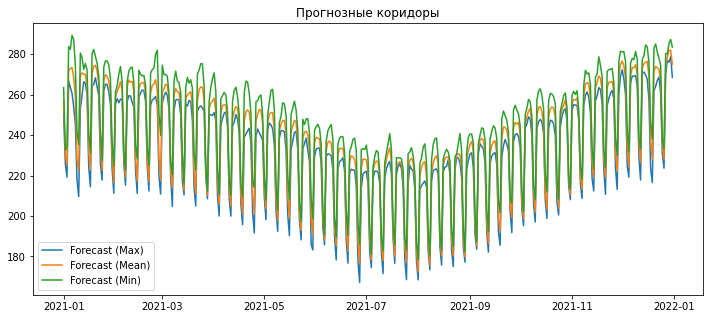

In [43]:
plt.plot(model.predict(start=start, end=end, exog=prMax))
plt.plot(model.predict(start=start, end=end, exog=prMean))
plt.plot(model.predict(start=start, end=end, exog=prMin))
plt.legend(["Forecast (Max)", "Forecast (Mean)", "Forecast (Min)"])
plt.title("Прогнозные коридоры")
plt.show()

## Обычная линейная регрессия

In [44]:
gas = pd.read_csv('data/gas.csv', index_col='Date', parse_dates=True)

In [45]:
gas.index.freq = 'D'

In [46]:
X = gas[["Mean temperature"]]

In [47]:
X = sm.add_constant(X)

In [48]:
y = gas["Consumption"]

In [49]:
model = OLS(y, X).fit()

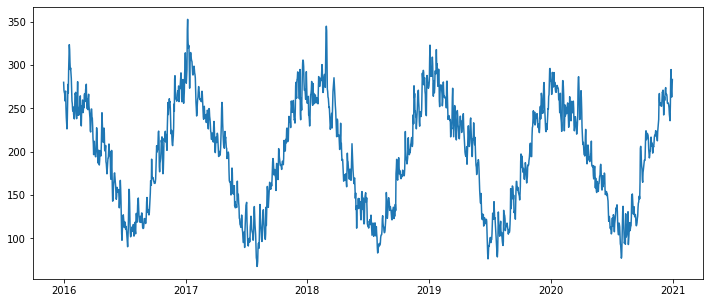

In [50]:
plt.plot(model.fittedvalues)
plt.show()

In [51]:
resid = y - model.fittedvalues

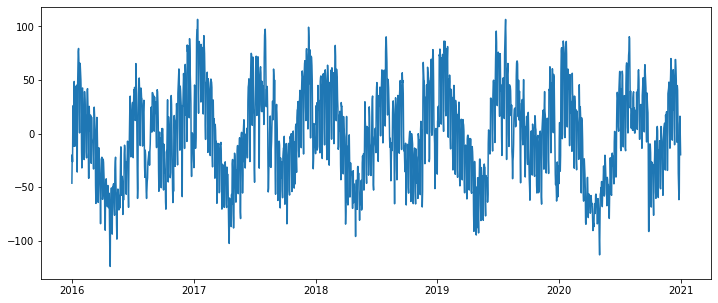

In [52]:
plt.plot(resid)
plt.show()

In [53]:
resModel = SARIMAX( resid,
                    order=(3, 1, 1),
                    seasonal_order=(2, 1, 1,
 7)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13711D+00    |proj g|=  6.02583D-02


 This problem is unconstrained.



At iterate    5    f=  4.09754D+00    |proj g|=  5.44745D-02

At iterate   10    f=  4.03590D+00    |proj g|=  7.78360D-03

At iterate   15    f=  4.03290D+00    |proj g|=  3.79605D-02

At iterate   20    f=  4.02387D+00    |proj g|=  3.55689D-03

At iterate   25    f=  4.02367D+00    |proj g|=  3.16776D-04

At iterate   30    f=  4.02360D+00    |proj g|=  4.59581D-03

At iterate   35    f=  4.02348D+00    |proj g|=  4.48437D-03

At iterate   40    f=  4.02336D+00    |proj g|=  1.41029D-03

At iterate   45    f=  4.02319D+00    |proj g|=  1.80670D-03


/home/egor/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.02312D+00    |proj g|=  1.01781D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   1.018D-03   4.023D+00
  F =   4.0231206784660563     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [54]:
resPred = resModel.predict(start=start, end=end).values

In [55]:
prMean = X.groupby([gas.index.month, gas.index.day]).mean()
prMin = X.groupby([gas.index.month, gas.index.day]).min()
prMax = X.groupby([gas.index.month, gas.index.day]).max()

In [56]:
for name in ["prMean", "prMax", "prMin"]:
    eval(f"{name}.drop((2,29), axis=0, inplace=True)")

In [57]:
predMean = model.predict(prMean.values)
predMin = model.predict(prMin.values)
predMax = model.predict(prMax.values)

In [58]:
dfPred = pd.Series(resPred + predMean, index=pd.date_range(start,end))
dfPredMin = pd.Series(resPred + predMin, index=pd.date_range(start,end))
dfPredMax = pd.Series(resPred + predMax, index=pd.date_range(start,end))

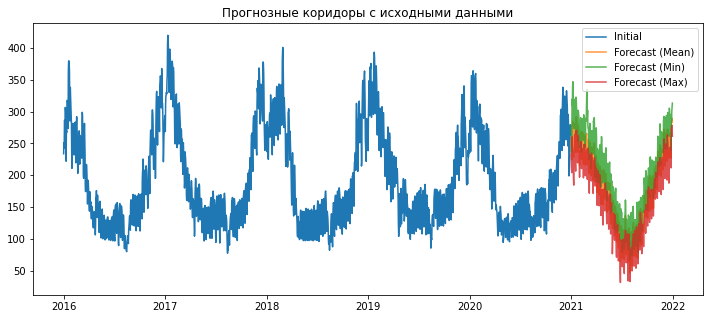

In [59]:
plt.plot(gas["Consumption"])
plt.plot(dfPred, alpha=0.8)
plt.plot(dfPredMin, alpha=0.8)
plt.plot(dfPredMax, alpha=0.8)
plt.legend(["Initial", "Forecast (Mean)", "Forecast (Min)", "Forecast (Max)"])
plt.title("Прогнозные коридоры с исходными данными")
plt.show()